In [1]:
%load_ext autoreload
%autoreload 2
from exojax.spec import make_numatrix0,voigt,lorentz
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec import rtransfer as rt
from exojax.spec import planck
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.lax import map, scan
from jax import vmap, jit
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from scipy.constants import Boltzmann, proton_mass, speed_of_light, m_u, Planck

In [3]:
import hapi
hapi.db_begin('/home/kawahara/exojax/data/CO')

HAPI version: 1.1.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005
Using /home/kawahara/exojax/data/CO

05_hit12
                     Lines parsed: 4606


In [4]:
#hapi.describeTable('05_HITEMP2019')

In [5]:
import pandas as pd
#Kawashima
dat=pd.read_csv("/home/kawahara/exojax/data/CO/05-1.0E-03bar_1.0E+00.dat",delimiter=",")
#Helios K
datH=pd.read_csv("/home/kawahara/HELIOS-K/Out_i.dat",delimiter="\s",names=("wn","val"))


/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


In [6]:
w=np.array(dat["wav"])*1.e4 #angstrom
wcm=np.array(dat["wav"])*1.e-4 #cm
#subtract Rayleigh scattering
aRay=1.95e-24
absco=dat["absco"]-128.0/3.0*np.pi**5*aRay**2/(wcm**4)

nusH=datH["wn"]
wH=1.e8/nusH #angstrom
absH=datH["val"]

In [7]:
import numpy as np
import astropy.units as u
#nm
llow=2290.0
lhigh=2450.0
#cm-1
wlow=1.e7/lhigh
whigh=1.e7/llow
wls = w[::-1]
nus = 100000000/wls
nu_lo, nu_hi = nus.min().astype(np.int), nus.max().astype(np.int)
#nus, wls = jnp.array(nus), jnp.array(wls)

In [8]:
molec='05_hit12'
A_all = hapi.getColumn(molec, 'a')
n_air_all = hapi.getColumn(molec, 'n_air')
isoid_all = hapi.getColumn(molec,'local_iso_id')
gamma_air_all = hapi.getColumn(molec, 'gamma_air')
gamma_self_all = hapi.getColumn(molec, 'gamma_self')
nu_lines_all = hapi.getColumn(molec, 'nu')
delta_air_all = hapi.getColumn(molec, 'delta_air')
S_ij_all = hapi.getColumn(molec, 'sw')
elower_all = hapi.getColumn(molec, 'elower')
gpp_all = hapi.getColumn(molec, 'gpp')

In [9]:
np.unique(isoid_all)

array([1, 2, 3, 4, 5, 6])

In [10]:
margin=np.inf
#crit=1.e-98
crit=0.0
#mask=(S_ij_all>crit)
mask=(nu_lines_all>nus[0]-margin)*(nu_lines_all<nus[-1]+margin)*(S_ij_all>crit)
#mask=(nu_lines_all>nus[0]-margin)*(nu_lines_all<nus[-1]+margin)#*(S_ij_all>crit)

A=A_all[mask]
n_air=n_air_all[mask]
gamma_air=gamma_air_all[mask]
gamma_self=gamma_self_all[mask] 
nu_lines=nu_lines_all[mask] 
delta_air=delta_air_all[mask]
S_ij0=S_ij_all[mask]
elower=elower_all[mask]
gpp=gpp_all[mask]

sij0=np.log(S_ij0) #use numpy not jnp

In [11]:
Tfix=1000.0

In [12]:
np.float32(Planck*speed_of_light/Boltzmann*1.e2)

1.4387773

In [13]:
#@jit
def QT(T, g_k, E_k):
    '''Total Internal Partition Sum'''
    c_2 = 1.4387773538277204 #cm K
    return np.sum( g_k * np.exp(- c_2 * E_k / T) )

In [16]:


@jit
def SijT(T,sij0,nu_ij,glower,elower,qT):
    """
    qT=Q(Tref)/Q(T)
    """
    c_2 = 1.4387773 
    expow=sij0-c_2*(elower/T-elower/Tref)
    fac=(1.0-jnp.exp(-c_2*nu_ij/T) )/(1.0-jnp.exp(-c_2*nu_ij/Tref))
    return jnp.exp(expow)*qT*fac

In [14]:
Tref=296.
Qr=hapi.partitionSum(5,1, [Tref,Tfix])
print(Qr[1]/Qr[0])
print(QT(Tfix, gpp_all, elower_all)/QT(Tref, gpp_all, elower_all))

3.540287620202548
3.5508362322238085


In [12]:
QT(Tref, gpp_all, elower_all)

17847.44461922804

In [13]:
@jit
def gamma_hitran(P, T, Pself, n_air, gamma_air_ref, gamma_self_ref):
    return (Tref/T)**n_air *(gamma_air_ref*(P-Pself) + gamma_self_ref*(Pself))


In [18]:
np.float32(np.sqrt(Boltzmann/m_u)/speed_of_light) # if T is given

3.0415595e-07

In [17]:
np.float32(1.e-2/speed_of_light/(4.0*np.pi))

2.6544188e-12

In [17]:
def gamma_natural(A):
    return 2.6544188e-12*A

In [18]:
def doppler_sigma(nu,T,M):
    c3=3.0415595e-07
    return c3*jnp.sqrt(T/M)*nu

In [15]:
@jit
def cross(numatrix,sigmaD,gammas,Sij):
    return jnp.dot((vvoigt(numatrix,sigmaD,gammas)).T,Sij)

In [16]:
def checkga(numatrix,sigmaD,gammaL): 
    minnu=np.min(np.abs(numatrix),axis=1)
    sfac=1.0/(np.sqrt(2)*sigmaD)
    x=sfac*minnu
    a=sfac*gammaL
    return x,a

In [17]:
#numatrix=nus[None,s:e]-nu_lines[:,None]-nu0fix
nus.dtype,nu_lines.dtype


(dtype('float64'), dtype('float64'))

In [19]:
s=0
e=10000
#numatrix=nus[None,:]-nu_lines[:,None]-nu0fix

In [20]:
np.max(nus)

33333.99999999973

In [21]:
s=0; e=10000
%timeit make_numatrix0(nus[s:e],nu_lines)

579 µs ± 127 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
Mmol=28.010446441149536
Tref=296.0
Tfix=1000.0
bar2atm=1.0/1.01325
Pfix=1.e-3*bar2atm#atm

nu0fix = np.array([0.0000],dtype=np.float64)
#-0.0002

Q0=QT(Tref, gpp_all, elower_all)
QTc=QT(Tfix, gpp_all, elower_all)
Sij=SijT(Tfix,sij0,nu_lines,gpp,elower,Q0/QTc)

gammas = vmap(gamma_hitran, in_axes=(None, None, None, 0, 0, 0)) \
(Pfix,Tfix,Pfix, n_air, gamma_air, gamma_self) \
#+ gamma_natural(A)

vvoigt=jit(vmap(voigt,(0,0,0),0)) #we assume all of the input is vmaped.
#vlorentz=jit(vmap(lorentz,(0,0),0))
sigmaD=doppler_sigma(nu_lines,Tfix,Mmol)



import tqdm
d=40000
Ni=int(len(nus)/d)
xsv=[]
xha=[]
aha=[]
for i in tqdm.tqdm(range(0,Ni+1)):
    s=int(i*d)
    e=int((i+1)*d)
    e=min(e,len(nus))
    #numatrix=nus[None,s:e]-nu_lines[:,None]-nu0fix #require double
    numatrix=make_numatrix0(nus[s:e],nu_lines)-nu0fix
    #xh,ah=checkga(numatrix,sigmaD,gammas)
    #xha=np.concatenate([xha,xh])
    #ha=np.concatenate([aha,xh])
    xsv = np.concatenate([xsv,cross(numatrix,sigmaD,gammas,Sij)])


  0%|          | 0/83 [00:00<?, ?it/s]

RuntimeError: Resource exhausted: Out of memory while trying to allocate 736960000 bytes.

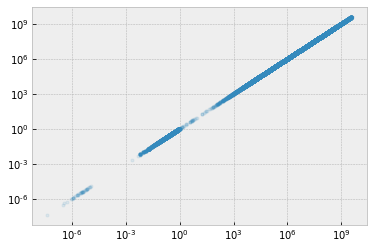

In [53]:
plt.plot(xha,aha,".",alpha=0.1)
plt.yscale("log")
plt.xscale("log")


In [35]:
llow=2359.4
lhigh=2359.6
llow=2250
lhigh=2400

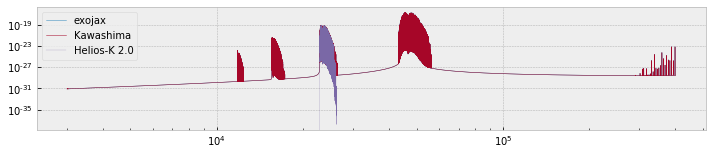

In [36]:
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(211)
plt.plot(wls,xsv,lw=0.5,label="exojax")
plt.plot(w,absco,lw=0.5,label="Kawashima")
plt.plot(wH,absH,label="Helios-K 2.0",lw=0.2)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="upper left")
plt.savefig("co_hitran.png")
plt.show()

In [59]:
wline=100000000/nu_lines
wline.dtype

dtype('float64')

In [60]:
len(wline)

4606

In [37]:
#Checking mass center +- 0.1 cm-1
wline=100000000/nu_lines
xsvc=xsv[::-1]
lw=len(w)
wid=10
xe=[]#center for exojax
xk=[]#center for kawashima
wca=[]
for wc in tqdm.tqdm(wline):
    i=np.searchsorted(w,wc)
    iq=i+wid
    ip=i-wid
    if iq<lw and ip>-1:
        xc_e=np.sum((1.e8/w[ip:iq])*xsvc[ip:iq])/np.sum(xsvc[ip:iq])
        xc_k=np.sum((1.e8/w[ip:iq])*absco[ip:iq])/np.sum(absco[ip:iq])
        xe.append((xc_e-1.e8/wc))
        xk.append((xc_k-1.e8/wc))
        wca.append(wc)
xe=np.array(xe)
xk=np.array(xk)
wca=np.array(wca)

100%|██████████| 4606/4606 [00:01<00:00, 2562.31it/s]


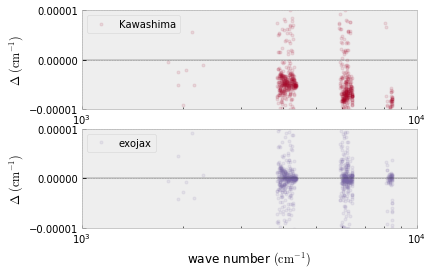

In [38]:
#+- 0.1 cm-1
fig=plt.figure()
ax=fig.add_subplot(211)
plt.plot(1.e8/wca,xk,".",alpha=0.1,color="C1",label="Kawashima")
plt.ylim(-0.00001,0.00001)
plt.xlim(1.e3,1.e4)
#plt.xlim(1.e4,3.e4)
plt.axhline(0.0,color="black",lw=0.3)
plt.ylabel("$\Delta \, \, (\mathrm{cm^{-1}})$")
plt.axhline(0.0002,lw=0.5)
plt.xscale("log")
plt.legend(loc="upper left")
ax=fig.add_subplot(212)
plt.plot(1.e8/wca,xe,".",alpha=0.1,color="C2",label="exojax")
#plt.plot(wca,xk,".")
plt.xscale("log")
plt.ylim(-0.00001,0.00001)
plt.xlim(1.e3,1.e4)
plt.axhline(0.0,color="black",lw=0.3)
plt.ylabel("$\Delta \, \, (\mathrm{cm^{-1}})$")
plt.axhline(0.0002,lw=0.5)
plt.legend(loc="upper left")
plt.xlabel("wave number $(\mathrm{cm}^{-1})$")
plt.savefig("center.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

In [124]:
llow=2300.4
lhigh=2300.7
1.e7/llow

4347.0700747696055

In [125]:
ii=np.searchsorted(w,wH[0])
iie=ii-len(wH)
wH=np.array(wH)
w[ii],w[iie],wH[0],wH[-1]
absHc=absH[::-1]
len(absHc),len(xsvc[iie:ii])

(60000, 60000)

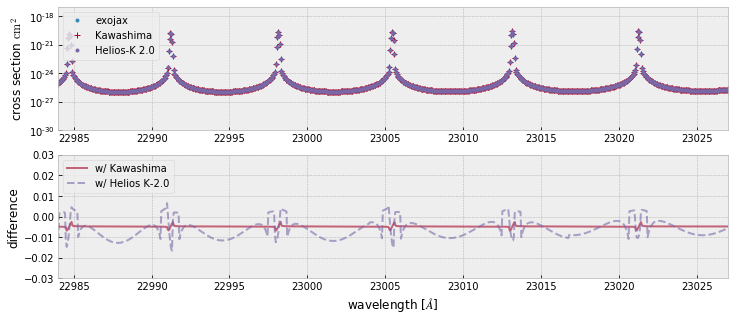

In [141]:
xsvc=xsv[::-1]
import matplotlib.pyplot as plt
#plt.plot(wls,xsv_l,lw=0.5,label="Lorentz")
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(211)
plt.plot(wls,xsv,".",lw=0.5,label="exojax",color="C0")
plt.plot(w,absco,"+",lw=0.5,label="Kawashima",color="C1")
plt.plot(wH,absH,".",label="Helios-K 2.0",color="C2")
plt.ylim(1.e-30,1.e-17)
plt.yscale("log")
tip=20.0
plt.xlim(llow*10.0-tip,lhigh*10.0+tip)
plt.legend(loc="upper left")
plt.ylabel("cross section $\mathrm{cm}^{2}$")
ax=fig.add_subplot(212)
plt.plot(w,(absco-xsvc)/absco,alpha=0.6,color="C1",\
          label="w/ Kawashima")
plt.plot(w[iie:ii],(absHc-xsvc[iie+1:ii+1])/absHc,color="C2",alpha=0.6,\
         ls="dashed",label="w/ Helios K-2.0")
plt.ylabel("difference")
#for iline in wline:
#    plt.axvline(iline,lw=0.3)
plt.xlim(llow*10.0-tip,lhigh*10.0+tip)
plt.ylim(-0.03,0.03)
plt.xlabel('wavelength [$\AA$]')
#plt.legend()
plt.legend(loc="upper left")
plt.savefig("comparison.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

In [160]:
(1-23001/23000)*300000

-13.043478260876817

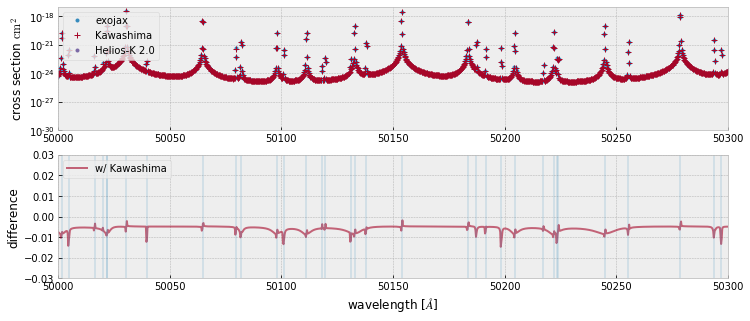

In [154]:
xsvc=xsv[::-1]
import matplotlib.pyplot as plt
#plt.plot(wls,xsv_l,lw=0.5,label="Lorentz")
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(211)
plt.plot(wls,xsv,".",lw=0.5,label="exojax",color="C0")
plt.plot(w,absco,"+",lw=0.5,label="Kawashima",color="C1")
plt.plot(wH,absH,".",label="Helios-K 2.0",color="C2")
plt.ylim(1.e-30,1.e-17)
plt.xlim(50000.0,50300.0)
plt.yscale("log")
plt.legend(loc="upper left")
plt.ylabel("cross section $\mathrm{cm}^{2}$")
ax=fig.add_subplot(212)
plt.plot(w,(absco-xsvc)/absco,alpha=0.6,color="C1",\
          label="w/ Kawashima")
#plt.plot(w[iie:ii],(absHc-xsvc[iie+1:ii+1])/absHc,color="C2",alpha=0.6,\
#         ls="dashed",label="w/ Helios K-2.0")
plt.ylabel("difference")
for iline in wline:
    plt.axvline(iline,lw=0.3)
plt.xlim(50000.0,50300.0)
plt.ylim(-0.03,0.03)
plt.xlabel('wavelength [$\AA$]')
#plt.legend()
#plt.xscale("log")
plt.legend(loc="upper left")
plt.savefig("comparison_wide.png")#, bbox_inches="tight", pad_inches=0.0)
plt.show()

In [99]:
print(numatrix.nbytes/1000/1000,"MB")

736.96 MB
